In [2]:
import torch
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pickle

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

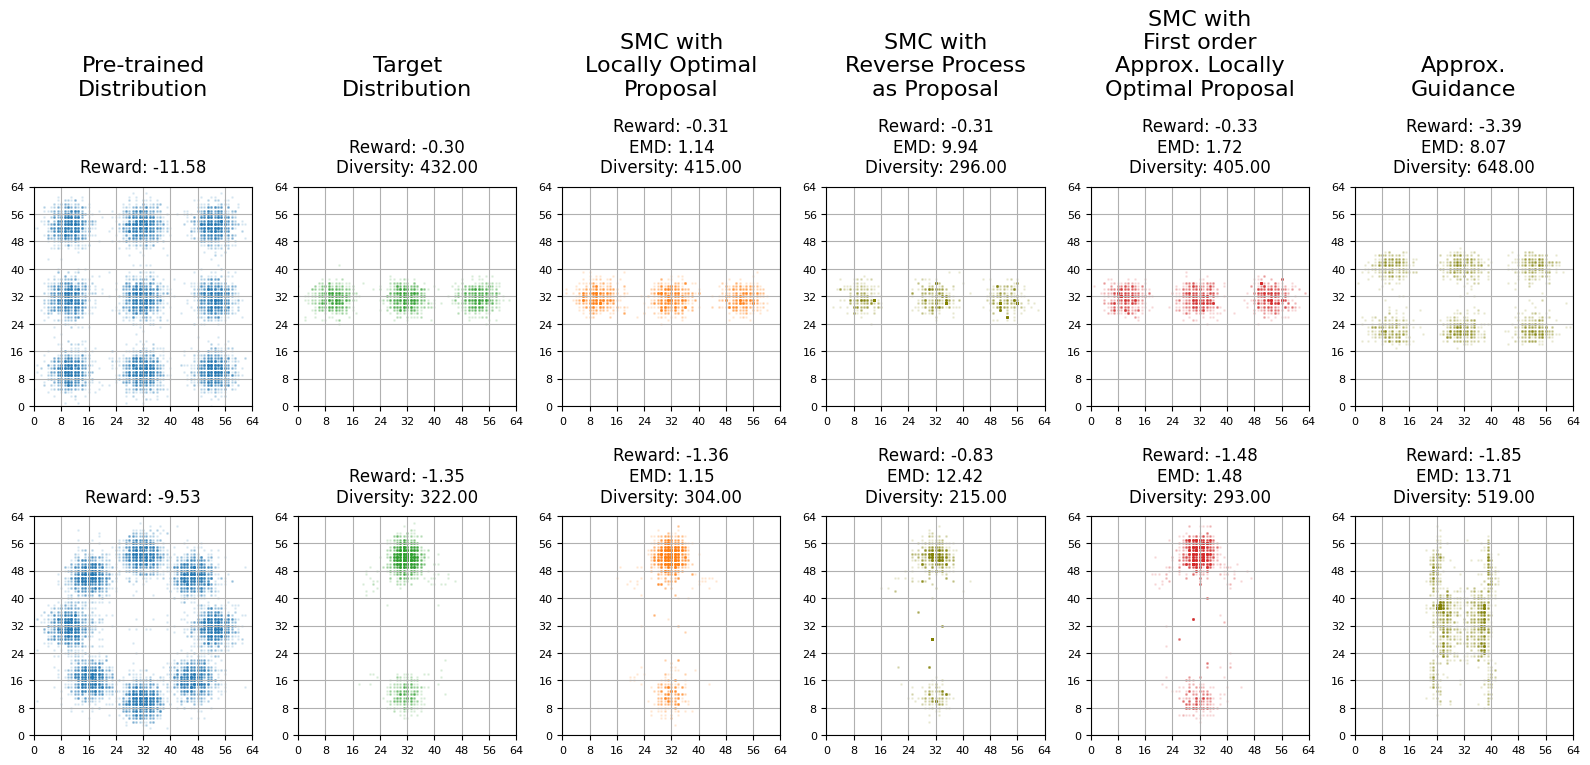

In [81]:
# 1) Load both datasets
with open("plot_data/smc_mdm_gmm1.pkl", "rb") as f:
    data1 = pickle.load(f)
with open("plot_data/smc_mdm_gmm2.pkl", "rb") as f:
    data2 = pickle.load(f)

all_data = {
    "GMM‑1": data1,
    "GMM‑2": data2,
}

# 2) Column order and colors
col_order  = ["pre_trained", "target", "locally_optimal", "reverse", "first_order", "guidance"]
col_titles = {
    "pre_trained":    "Pre‑trained\nDistribution",
    "target":         "Target\nDistribution",
    "locally_optimal":"SMC with\nLocally Optimal\nProposal",
    "reverse":        "SMC with\nReverse Process\nas Proposal",
    "guidance":       "Approx.\nGuidance",
    "first_order":    "SMC with\nFirst order\nApprox. Locally\nOptimal Proposal",
}
col_colors = {
    "pre_trained":    "tab:blue",
    "target":         "tab:green",
    "locally_optimal":"tab:orange",
    "reverse":        "olive",
    "guidance":       "olive",
    "first_order":    "tab:red",
}

# 3) Plot
n_rows, n_cols = len(all_data), len(col_order)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(20 * 0.8, 10 * 0.8),
                         squeeze=False)

for i, (row_name, methods_dict) in enumerate(all_data.items()):
    for j, meth in enumerate(col_order):
        ax = axes[i, j]
        block = methods_dict[meth]
        X = block["samples"]
        r = block.get("reward", np.nan)
        e = block.get("emd", None)
        diversity = block.get("diversity", None)

        # scatter with your chosen color
        ax.scatter(X[:,0], X[:,1],
                   s=1, alpha=0.1,
                   color=col_colors[meth])

        ax.set_xlim(0, 64)
        ax.set_ylim(0, 64)
        ax.set_xticks([tick for tick in range(0, 65, 8)])
        ax.set_yticks([tick for tick in range(0, 65, 8)])
        ax.tick_params(axis='both', labelsize=8)
        ax.grid(True)

        
        # 1) Main title line (only top row), even higher
        if i == 0:
            ax.text(
                0.5, 1.4,                       # <-- y bumped up from 1.12 → 1.18
                col_titles[meth],
                transform=ax.transAxes,
                ha="center", va="bottom",
                fontsize=16
            )

        # 2) Subtitle with reward/EMD, pushed further down
        subtitle = f"Reward: {r:.2f}"
        if e is not None:
            subtitle += f"\nEMD: {e:.2f}"
        if diversity is not None:
            subtitle += f"\nDiversity: {diversity:.2f}"
        ax.set_title(subtitle,
                     fontsize=12,
                     pad=10)                    # <-- increased pad from 20 → 25

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # <-- increase vertical space between rows
plt.savefig("plots/gmm_comparison_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [61]:
def plot_traces(plot_data_file, plot_save_file, trace_type):
    # 1) Load both datasets
    with open(plot_data_file, "rb") as f:
        data1 = pickle.load(f)
        
    methods  = ["locally_optimal", "reverse", "first_order"]
    labels = {
        "locally_optimal":"Locally Optimal Proposal",
        "reverse":        "Reverse Process as Proposal",
        "first_order":    "First order Approx. Locally Optimal Proposal",
    }

    timesteps = np.arange(100, -1, -1)  # array of 101 points

    plt.figure(figsize=(6, 4))
    for method in methods:
        if trace_type == "rewards":
            trace_data = np.array(data1[method]["reward_trace"]).mean(axis=1)
        elif trace_type == "ess":
            trace_data = np.array(data1[method]["ess_trace"])
        else:
            raise ValueError("Invalid trace type")
            
        # resampling times (array of τ values)
        resamps = np.array(data1[method]["resampling_trace"])
        
        # 1) plot the reward curve
        line, = plt.plot(timesteps, trace_data, label=labels[method], linewidth=1.0)
        
        # 2) sample the reward at each resampling τ
        #    (assuming resamps holds values in [0..100] matching timesteps)
        y_resamp = trace_data[100 - resamps]
        #    note: if your reward_trace is ordered t=100→0 then index by (100 - τ)
        
        # 3) scatter square markers at those points, using same color
        plt.scatter(
            resamps,        # x-coordinates
            y_resamp,       # y-coordinates
            marker='s',     # square marker
            s=10,           # size of marker
            # facecolors='none', 
            edgecolors=line.get_color(), 
            linewidths=1.5,
            zorder=3
        )

    plt.gca().invert_xaxis()
    plt.xlabel(r"Time step $\tau$")
    plt.xlim(100, 0)
    ylabel = "Reward" if trace_type == "rewards" else "ESS"
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(plot_save_file, format="pdf", bbox_inches="tight")
    plt.show()

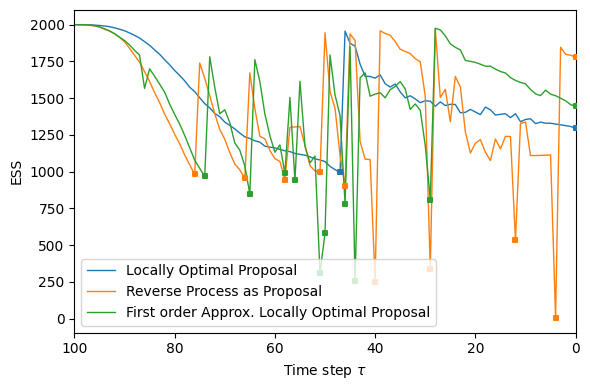

In [66]:
plot_traces(
    plot_data_file="plot_data/smc_mdm_gmm2.pkl", 
    plot_save_file="plots/smc_mdm_gmm1_reward_trace", 
    trace_type="ess"
)

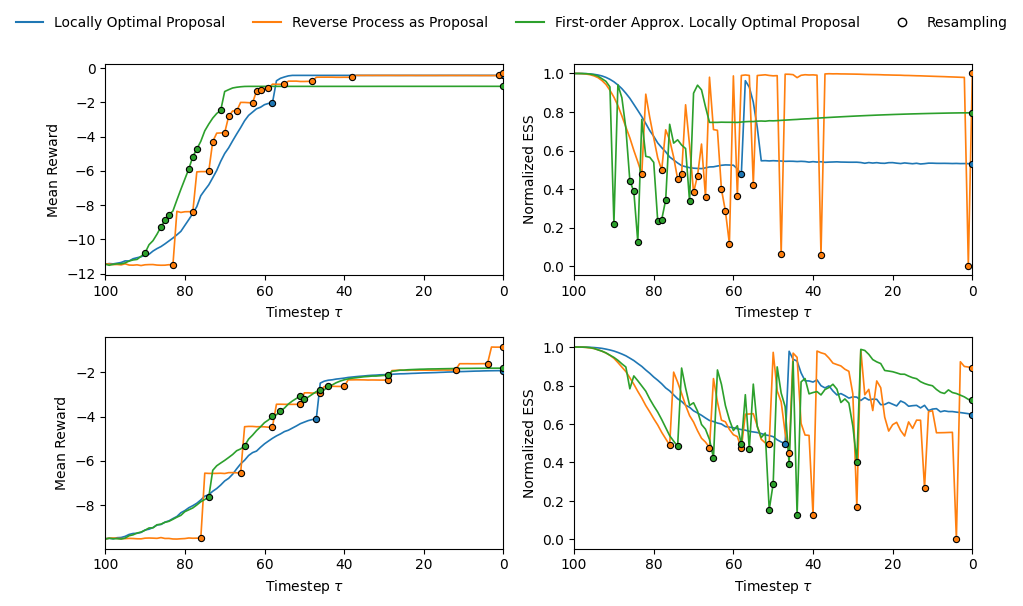

In [105]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_all_traces(data_files, trace_types):
    """
    data_files: list of two paths, e.g. ["plot_data/smc_mdm_gmm1.pkl", "plot_data/smc_mdm_gmm2.pkl"]
    save_files: corresponding list of two base names (not used here but could be for titles)
    trace_types: list of two strings, ["reward", "ess"]
    """
    methods  = ["locally_optimal", "reverse", "first_order"]
    labels = {
        "locally_optimal":"Locally Optimal Proposal",
        "reverse":        "Reverse Process as Proposal",
        "first_order":    "First‐order Approx. Locally Optimal Proposal",
    }
    markers = {
        "locally_optimal":"o",
        "reverse":        "o",
        "first_order":    "o",
    }
    timesteps = np.arange(100, -1, -1)  # 101 → 0

    fig, axes = plt.subplots(2, 2, figsize=(12 * 0.8, 8 * 0.8))

    # Prepare custom legend handles including line style and a separate resample entry
    legend_handles = []
    legend_labels = []
    for method in methods:
        # Generate a prototype handle for each method
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][methods.index(method)]
        handle = Line2D(
            [0], [0],
            color=color,
            lw=1.5,
            label=labels[method]
        )
        legend_handles.append(handle)
        legend_labels.append(labels[method])
    
    # Add a generic resampling marker entry
    res_handle = Line2D(
        [0], [0],
        color='white',  # invisible line
        marker='o',
        markerfacecolor='none',
        markeredgecolor='black',
        markersize=6,
        linestyle='None',
        label='Resampling'
    )
    legend_handles.append(res_handle)
    legend_labels.append('Resampling')

    for i, data_file in enumerate(data_files):
        with open(data_file, "rb") as f:
            data = pickle.load(f)

        for j, trace_type in enumerate(trace_types):
            ax = axes[i, j]
            for method in methods:
                td = np.array(data[method][f"{trace_type}_trace"])
                trace_data = td.mean(axis=1) if trace_type == "reward" else td / 2000

                resamps = np.array(data[method]["resampling_trace"])
                y_resamp = trace_data[100 - resamps]

                # plot line
                line, = ax.plot(
                    timesteps,
                    trace_data,
                    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][methods.index(method)],
                    linewidth=1.2
                )
                # filled marker at resamples
                ax.scatter(
                    resamps,
                    y_resamp,
                    marker=markers[method],
                    s=20,
                    color=line.get_color(),
                    edgecolors='black',
                    linewidths=0.8,
                    zorder=3
                )

            ax.invert_xaxis()
            ax.set_xlim(100, 0)
            ax.set_xlabel(r"Timestep $\tau$")
            ylabel = "Mean Reward" if trace_type == "reward" else "Normalized ESS"
            ax.set_ylabel(ylabel)

    # Add single legend at top including custom handles
    fig.subplots_adjust(top=0.88)
    fig.legend(
        legend_handles,
        legend_labels,
        loc='upper center',
        ncol=len(legend_handles),
        frameon=False,
        bbox_to_anchor=(0.5, 0.95)
    )

    plt.tight_layout(rect=[0, 0, 1, 0.88])  # leave space at top for legend
    plt.savefig("plots/gmm_traces.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Usage example
plot_all_traces(
    data_files=["plot_data/smc_mdm_gmm1.pkl", "plot_data/smc_mdm_gmm2.pkl"],
    trace_types=["reward", "ess"]
)

In [4]:
def plot_binarized_mnist_results(plot_data_file, plot_save_file):
    # Load data
    with open(plot_data_file, "rb") as f:
        plot_data = pickle.load(f)

    methods = ["reverse", "first_order", "approx_guidance"]
    col_titles = {
        # "pre_trained":    "Pre‑trained\nDistribution",
        # "target":         "Target\nDistribution",
        # "locally_optimal":"SMC with\nLocally Optimal\nProposal",
        "reverse":        "SMC with\nReverse Process\nas Proposal",
        "approx_guidance":       "Approx.\nGuidance",
        "first_order":    "SMC with\nFirst order\nApprox. Locally\nOptimal Proposal",
    }

    # Create figure with 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(6, 3), constrained_layout=True)

    for ax, method in zip(axes, methods):
        # samples: (20, 1, 28, 28) as numpy int64 → convert to float tensor
        samples = torch.from_numpy(plot_data[method]["samples"]).float()
        
        # make_grid: nrow=4 → 5 rows × 4 cols = 20 images
        grid = make_grid(samples, nrow=4, normalize=False)
        
        # move channel dim to last and plot
        npimg = grid.numpy().transpose((1, 2, 0))
        ax.imshow(npimg.squeeze(), cmap='gray', vmin=0, vmax=1)
        title = col_titles[method]
        # ax.set_title(title)
        # 1) Main title line (only top row), even higher
        ax.text(
            0.5, 1.2,                       # <-- y bumped up from 1.12 → 1.18
            title,
            transform=ax.transAxes,
            ha="center", va="bottom",
            fontsize=12
        )
        r = plot_data[method]["reward"]
        subtitle = f"Reward: {r:.2f}"
        ax.set_title(subtitle,
                        fontsize=10,
                        pad=5) 
        
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(plot_save_file, format="pdf", bbox_inches="tight")
    plt.show()

C:\Users\91811\AppData\Local\Temp\ipykernel_18268\1868766975.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


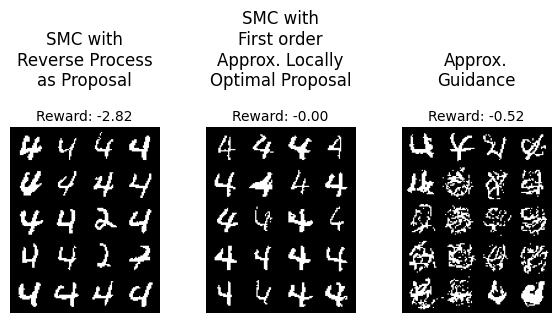

In [5]:
plot_binarized_mnist_results(
    plot_data_file="plot_data/smc_mdm_binarized_mnist.pkl", 
    plot_save_file="plots/mdm_mnist_comparison_plot.pdf",
)

C:\Users\91811\AppData\Local\Temp\ipykernel_18268\1868766975.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


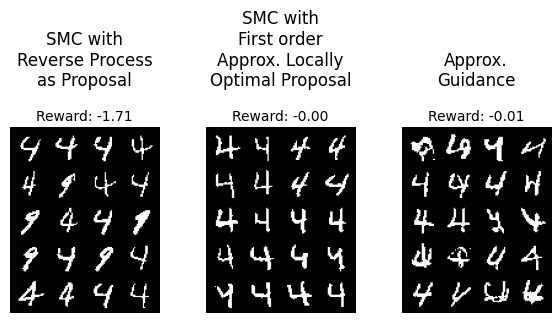

In [11]:
plot_binarized_mnist_results(
    plot_data_file="plot_data/smc_remdm_binarized_mnist.pkl", 
    plot_save_file="plots/remdm_mnist_comparison_plot.pdf",
)

C:\Users\91811\AppData\Local\Temp\ipykernel_18268\1868766975.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


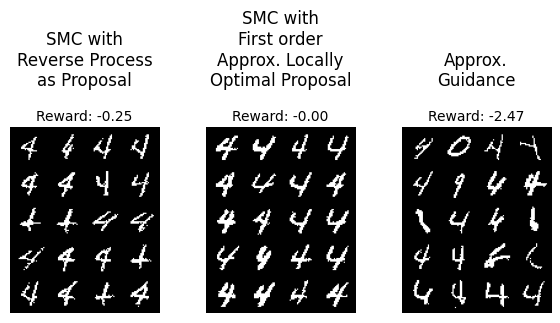

In [13]:
plot_binarized_mnist_results(
    plot_data_file="plot_data/smc_udm_binarized_mnist.pkl", 
    plot_save_file="plots/udm_mnist_comparison_plot.pdf",
)

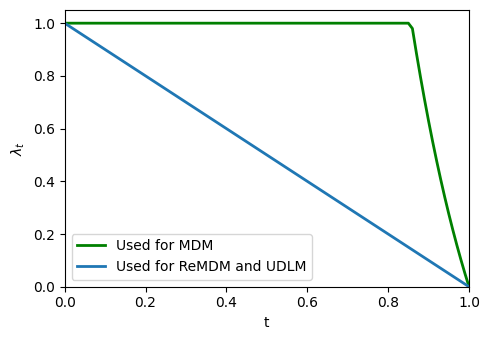

In [129]:
from smc.utils import lambda_schedule

lambdas = lambda_schedule(num_timesteps=100, gamma=0.05)
fig = plt.figure(figsize=(5, 3.5))
t = np.linspace(0, 1, len(lambdas))
plt.plot(t, lambdas, color='green', label='Used for MDM', lw=2.0)
plt.plot(t, 1 - t, label='Used for ReMDM and UDLM', lw=2.0)
# plt.yticks([0, 0.5, 1])
# plt.xticks([0, 0.5, 1])
plt.xlim(0, 1)
plt.ylim(0)
plt.xlabel('t')
plt.ylabel(r'$\lambda_t$')

# Move legend outside the plot area (to the right)
# plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)
plt.legend()

plt.tight_layout()
plt.savefig("plots/mdm_lambda_schedule.pdf", format="pdf", bbox_inches="tight")
plt.show()